# Cyberint's workshop
## Eitan Lifshits | Data Scientist
### The goals of the workshop are: 
* Develope text classification Machine Learning algorithm
* Use scikit-learn package in a more advanced and flexible way (mainly Pipeline class)

## We'll work on a main classification task including the following steps:
1. Load data and make some preliminary explorations
2. Data preprocessing
3. Feature Extraction
4. Train classifier 
6. Analyze the results

For the whole process, we'll use the sklearn Pipeline class to include it all in one class (and train it)

Comment: The goal of the workshop is not necessarily getting the highest model performance , but rather try as many pipline features as possible to apply on future projects

## Data Description
Cyberint is aiming to find the most interesting items (cyber related posts) within large amount of retrieved data from hundreds of sources.
One of Cyberint's main problems is the amount of noise including many insignificant posts.
In the workshop we'll try to find the interesting posts from a Twitter dataset.
Each example has four fields:
* Content - the body of the message
* Author - The name of the user, as they’ve defined it. Not necessarily a person’s name. Typically capped at 20 characters, but subject to change.
* Author Handle - screen name, handle, or alias that this user identifies themselves with.
* Label - 1 if interesting and 0 otherwise. That field was manualy filled by analysts specializing in cyber security.

We will use a train set for development (60,607 examples) and evaluate our final models on out of sample dataset (15,152 examples)

## Import packages

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
import json
from sklearn.metrics import classification_report, confusion_matrix

## Preliminary data exploration

In [10]:
with open('./itc_data_train.json', 'r') as fp:
    data = json.load(fp) 

In [11]:
# Get data type
print('Data type: %s:' % type(data))
print('Data length: %d' % len(data))

Data type: <class 'list'>:
Data length: 64395


# Naive Bag of Words and Tfidf feature extraction and linear SVM classifier
Quick reminder of BoW and tfidf
* BoW: Given a set of documents, creating a NxD matrix structure, where N is the number of documents and D is the vocabulary size. The columns are the feature space and are the vocabulary including all terms in all docs.  
So, Element i, j contains the frecuency of term j in document i
* Tfidf: A method to assign weights for each document term, taking into consideration the frequency of a term in a documnt (tf) and the frequency of a term accross all documents (df)  
* TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).  
* IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

IDF(t) = log(Total number of documents / Number of documents with term t in it).  
The filnal weight will be: tfidf = tf x idf  

Example:  
Consider a document containing 100 words wherein the word cat appears 3 times. The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.


In [12]:
df = pd.DataFrame(data)
for i in df:
    print(df[i][0:5].values)
df.head()

['Tatsuya' '🌹kaylee🌹' 'Ian' 'riverhomes' 'Mike']
['@tdaitoku' '@kimchanhim' '@IanThinji' '@riverhomes' '@TensionShoppers']
[ 'Microsoft addresses CVE-2017-11826 Office Zero-Day used to deliver malware http://securityaffairs.co/wordpress/64163/hacking/cve-2017-11826-office-zero-day.html'
 '@xXLilMPhamXx okay but he actually looks creepy here asdfghjkl'
 '"The only person you should try to be better than is the person you were yesterday."\n--Anonymous'
 'Plans for developing Chiswick’s Dukes Meadows inc. riverside cafe with great views of the Thames:\n#thamespath #park… https://twitter.com/i/web/status/920944278385430528'
 '@soledadobrien Eww....she’s like some poorly-written, but creepy, character from a bad USA Network dystopian-future drama']
[1 0 0 0 0]


author     author_handle  \
0     Tatsuya         @tdaitoku   
1    🌹kaylee🌹       @kimchanhim   
2         Ian        @IanThinji   
3  riverhomes       @riverhomes   
4        Mike  @TensionShoppers   

                                             content  label  
0  Microsoft addresses CVE-2017-11826 Office Zero...      1  
1  @xXLilMPhamXx okay but he actually looks creep...      0  
2  "The only person you should try to be better t...      0  
3  Plans for developing Chiswick’s Dukes Meadows ...      0  
4  @soledadobrien Eww....she’s like some poorly-w...      0

Text(0.5,1,'label distribution')

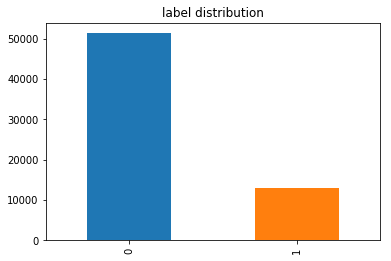

In [13]:
df['label'].value_counts().plot(kind = "bar")
plt.title("label distribution")

In [14]:
bad_df = df[df["label"] == 1]


Text(0.5,1,'author distribution')

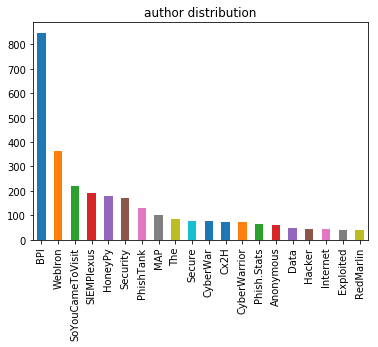

In [15]:
bad_df.author.value_counts()[0:20].plot(kind = "bar")
plt.title("author distribution")

## Exploring the Bag Of Word structure

In [16]:
text = "the quick brown fox jumped over the lazy dog"

In [17]:
count_vect = CountVectorizer(stop_words="english",strip_accents="ascii", lowercase=True, max_df = .7)
tokenizer = count_vect.build_tokenizer()
analyzer = count_vect.build_analyzer()

print(tokenizer(text))
print(analyzer(text))


['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']
['quick', 'brown', 'fox', 'jumped', 'lazy', 'dog']


## implement bag of words

In [46]:
count_vect = CountVectorizer(stop_words="english",strip_accents="ascii", lowercase=True, max_df = .7, min_df= .05)
X_bow = count_vect.fit_transform(df.content)
features = np.asarray(count_vect.get_feature_names())
print(features)
len(features)

['anonymous' 'com' 'creepy' 'http' 'https' 'phishing' 'status' 'twitter'
 'web' 'www']


10

In [47]:
bow_vect = X_bow[0].toarray()[0]
pos_indices = bow_vect > 0
list(zip(features[pos_indices], bow_vect[pos_indices]))

[('http', 1)]

## Adding customized pre-processing
Sometimes, we would like to add our own pre-processing methods. E.g: Stemming, Lemmatizing, etc.
Stemming: Convert each word to its root. E.g. hacker, hacking, hacked => hack

In [48]:
df.head()

author     author_handle  \
0     Tatsuya         @tdaitoku   
1    🌹kaylee🌹       @kimchanhim   
2         Ian        @IanThinji   
3  riverhomes       @riverhomes   
4        Mike  @TensionShoppers   

                                             content  label  
0  Microsoft addresses CVE-2017-11826 Office Zero...      1  
1  @xXLilMPhamXx okay but he actually looks creep...      0  
2  "The only person you should try to be better t...      0  
3  Plans for developing Chiswick’s Dukes Meadows ...      0  
4  @soledadobrien Eww....she’s like some poorly-w...      0

In [49]:
[df.content.values]

[array([ 'Microsoft addresses CVE-2017-11826 Office Zero-Day used to deliver malware http://securityaffairs.co/wordpress/64163/hacking/cve-2017-11826-office-zero-day.html',
        '@xXLilMPhamXx okay but he actually looks creepy here asdfghjkl',
        '"The only person you should try to be better than is the person you were yesterday."\n--Anonymous',
        ...,
        'Russian Cyberspies Are Rushing to Exploit Recent Flash 0-Day Before It Goes Cold https://www.bleepingcomputer.com/news/security/russian-cyberspies-are-rushing-to-exploit-recent-flash-0-day-before-it-goes-cold/',
        '@hannahjo928 also, it looks super creepy!!! i get bad vibes seeing it in people’s houses, idk 😬',
        "@Gqmerr @Sezleyy Couldn't move then get timed out you where probably getting ddos"], dtype=object)]

In [50]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmer_analyzer(doc):
    return (stemmer.stem(w) for w in analyzer(doc))


In [51]:

count_vect = CountVectorizer()
count_vect_stemmer = CountVectorizer(analyzer = stemmer_analyzer)

count_vect.fit_transform([df.content.values[0]])
count_vect_stemmer.fit_transform([df.content.values[0]])

for word in zip(count_vect.get_feature_names(), count_vect_stemmer.get_feature_names()):
    print (word)

('11826', '11826')
('2017', '2017')
('64163', '64163')
('addresses', 'address')
('co', 'co')
('cve', 'cve')
('day', 'day')
('deliver', 'deliv')
('hacking', 'hack')
('html', 'html')
('http', 'http')
('malware', 'malwar')
('microsoft', 'microsoft')
('office', 'offic')
('securityaffairs', 'securityaffair')
('to', 'to')
('used', 'use')
('wordpress', 'wordpress')
('zero', 'zero')


## Exercise
Write a customized analyzer to remove terms which are only digits

## Solution

In [52]:
analyzer = CountVectorizer().build_analyzer()

def analyzer_remove_digits(doc):
    return (w for w in analyzer(doc) if not w.isdigit())

In [53]:
count_vect_remove_digits = CountVectorizer(analyzer= analyzer_remove_digits)
count_vect_remove_digits.fit_transform(["hello 12345 world 6789"])
print(count_vect_remove_digits.get_feature_names())

['hello', 'world']


### Comment
Stemming may take a long time to apply and may be problematic, especialy in online processes.
Hence, we won't use it in the following designs

## Adding Tfidf weighting

In [54]:
count_vect = CountVectorizer()
tfidf_trans = TfidfTransformer()
X_bow = count_vect.fit_transform(df.content[:1000])
X_tfidf = tfidf_trans.fit_transform(X_bow)

features = np.array(count_vect.get_feature_names())
bow_vect = X_bow[0].toarray()[0]
pos_indices = bow_vect > 0
list(zip(features[pos_indices],bow_vect[pos_indices], X_tfidf.toarray()[0][pos_indices]))

[('11826', 2, 0.41258999984368411),
 ('2017', 2, 0.24422634351575609),
 ('64163', 1, 0.20629499992184205),
 ('addresses', 1, 0.20629499992184205),
 ('co', 1, 0.083826797854329213),
 ('cve', 2, 0.34977111206380579),
 ('day', 2, 0.27547783060658232),
 ('deliver', 1, 0.19470270872519874),
 ('hacking', 1, 0.1602809963226057),
 ('html', 1, 0.14046384362930989),
 ('http', 1, 0.072565031817720629),
 ('malware', 1, 0.15066121876715088),
 ('microsoft', 1, 0.18009814901590152),
 ('office', 2, 0.38940541745039747),
 ('securityaffairs', 1, 0.19470270872519874),
 ('to', 1, 0.072168857701366371),
 ('used', 1, 0.16666069453525037),
 ('wordpress', 1, 0.15066121876715088),
 ('zero', 2, 0.30132243753430177)]

## Apply a classifier on our data
We apply linear SVM as an example, as it works well with high dimensional text features

In [55]:
train, test = train_test_split(data, test_size = .25)
X_train = [d["content"] for d in train]
y_train = [d["label"] for d in train]

X_test = [d["content"] for d in test]
y_test = [d["label"] for d in test]


In [56]:

clf = LinearSVC()

tfidf_vect = TfidfVectorizer()

# fit on train for tfidf train
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

print (classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.97      0.97     12847
          1       0.88      0.91      0.89      3252

avg / total       0.96      0.96      0.96     16099



# Using pipeline to include both steps in one object
The idea of pipeline is to allow creating a full model cycle in one class constructs of several steps, where the output of each step is the input of the consecutive one (until the predict step)

In [57]:
pipeline_base = Pipeline(steps = [("tfidf", TfidfVectorizer()),
                                  ("clf", LinearSVC())])

In [58]:
pipeline_base.fit(X_train, y_train)
y_pred = pipeline_base.predict(X_test)
print("classification_report:" )
print(classification_report(y_test, y_pred))
print("confusion matrix:" )


classification_report:
             precision    recall  f1-score   support

          0       0.98      0.97      0.97     12847
          1       0.88      0.91      0.89      3252

avg / total       0.96      0.96      0.96     16099

confusion matrix:


### Defining funciton to fit and evaluate a model 

In [59]:
# A function that receives a pipeline and test set and show evaluation results
def evaluate_model(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

In [60]:
evaluate_model(pipeline_base, X_train, y_train, X_test, y_test)

             precision    recall  f1-score   support

          0       0.98      0.97      0.97     12847
          1       0.88      0.91      0.89      3252

avg / total       0.96      0.96      0.96     16099

[[12449   398]
 [  305  2947]]


## Using other fields as well
In our first model we used only the "content" field, but other fields might be informative as well.
We can either concatenate the desired fields with a space.

## Creating custom classes in sklearn
Sklearn allows to create custom classes to be part of the pipeline.  
It can either be preprocessing, feature extraction or algorithm.

The only rules are that each class must include a "transform" and a "fit" methods. And if it's an algorithm (say, classifier) it should include a "predict" method as well.  Must inherint from BaseEstimator class

We'll use it for preprocessing.



In [61]:
from sklearn.base import BaseEstimator

class ConcatData(BaseEstimator):
    
    def __init__(self):
        self.fields = ["content","author","author_handle"]
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, data):
        texts = []
        for d in data:
            field_txt = [d.get(key) for key in self.fields]
            texts.append(" ".join(txt for txt in field_txt))
            
        return texts

In [62]:
cd = ConcatData()
x = cd.transform(data)
x[:10]

['Microsoft addresses CVE-2017-11826 Office Zero-Day used to deliver malware http://securityaffairs.co/wordpress/64163/hacking/cve-2017-11826-office-zero-day.html Tatsuya @tdaitoku',
 '@xXLilMPhamXx okay but he actually looks creepy here asdfghjkl 🌹kaylee🌹 @kimchanhim',
 '"The only person you should try to be better than is the person you were yesterday."\n--Anonymous Ian @IanThinji',
 'Plans for developing Chiswick’s Dukes Meadows inc. riverside cafe with great views of the Thames:\n#thamespath #park… https://twitter.com/i/web/status/920944278385430528 riverhomes @riverhomes',
 '@soledadobrien Eww....she’s like some poorly-written, but creepy, character from a bad USA Network dystopian-future drama Mike @TensionShoppers',
 'Damn gurl you make me so hard.\n- me, to Medusa probably. You @Blue_Star_80',
 'I FUCKING HATE HOW FUCKING CREEPY IS THIS CHICK Love, @Mqrvelstony',
 '#Botnets, the bad part of #IoT and how to escape it? - Fullestop Blogs https://buff.ly/2yOzN0M\n#Malware #DDoS… ht

In [63]:

pipeline_multi_fields = Pipeline(steps = [("concat_fields", ConcatData()),
                                  ("tfidf", TfidfVectorizer()),
                                  ("clf", LinearSVC())])


evaluate_model(pipeline_multi_fields, train, [d["label"] for d in train], test, [d["label"] for d in test])

             precision    recall  f1-score   support

          0       0.98      0.97      0.97     12847
          1       0.88      0.92      0.90      3252

avg / total       0.96      0.96      0.96     16099

[[12420   427]
 [  252  3000]]


## Multiple BoWs
Another approach may be creating a different BoW (maybe with different hyperparameters) for each field and then concatenate them as the classifier input.    
For that, we'll create a class GetField to return the desired field data

In [64]:
class GetField(BaseEstimator):
    def __init__(self, field):
        self.field = field
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, data):
        return [d[self.field] for d in data]

In [65]:
gf = GetField("author")
x = gf.transform(data)
x[:10]

['Tatsuya',
 '🌹kaylee🌹',
 'Ian',
 'riverhomes',
 'Mike',
 'You',
 'Love,',
 'Chris',
 'United',
 'Arnaud']

In [68]:
pipeline_multi_features = Pipeline([
    
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for author using BoW
            ('author', Pipeline([
                ('get_field', GetField('author')),
                ('tfidf', TfidfVectorizer()),
            ])),

            # Pipeline for author_handle using chars n-grams
            ('author_handle', Pipeline([
                ('get_field', GetField('author_handle')),
                ('tfidf', TfidfVectorizer()),
            ])),

            # Pipeline for author_handle using chars n-grams
            ('content', Pipeline([
                ('get_field', GetField('content')),
                ('tfidf', TfidfVectorizer()),
            ])),

        ],

    )),

    ('clf', LinearSVC()),
])

In [69]:
evaluate_model(pipeline_multi_features, train, 
               [d['label'] for d in train], test, [d['label'] for d in test])

             precision    recall  f1-score   support

          0       0.98      0.97      0.97     12847
          1       0.88      0.90      0.89      3252

avg / total       0.96      0.96      0.96     16099

[[12462   385]
 [  314  2938]]


## Exercise
We may consider the number of time an author occured in the dataset as a feature.  
Write a class to create that feature together with all the current features  
* make sure to normalize the results and return a sparse matrix
* You can use Counter from collection package for the frequencies

## Solution

In [70]:
from collections import Counter
from scipy import sparse
# normalize by train set

def AuthorFreq(BaseEstimator):
    def __init__(self, field):
        self.field = field
        self.frequency = None
        self.std = std
        self.mean = mean
        
    def fit(self, X, y = None):
        self.frequency = Counter([d.get(self.field) for d in X])
        self.std = np.std(list(self.frequency.values()))
        self.mean = np.mean(list(self.frequency.values()))
    
    def transform(self, data):
        return sparse.csr_matrix([(self.frequency[d[self.field]]) - self.mean / self.std for d in data]).T


In [71]:
pipeline_multi_features = Pipeline([
    
    ('union', FeatureUnion(
        transformer_list=[
            
            # frequency classy
            ('freq', Pipeline([
                ('author_freq', AuthorFreq('author')),
            ])),
            
            # Pipeline for author using BoW
            ('author', Pipeline([
                ('get_field', GetField('author')),
                ('tfidf', TfidfVectorizer()),
            ])),

            # Pipeline for author_handle using chars n-grams
            ('author_handle', Pipeline([
                ('get_field', GetField('author_handle')),
                ('tfidf', TfidfVectorizer()),
            ])),

            # Pipeline for author_handle using chars n-grams
            ('content', Pipeline([
                ('get_field', GetField('content')),
                ('tfidf', TfidfVectorizer()),
            ])),

        ],

    )),

    ('clf', LinearSVC()),
])

## Applying hyperparameters grid search
We would like to tune both BoW and SVM's hyperparameters at ones.  I.e. each parameters set may include several steps.  
We use GridSearchCV for k-folds cross validation optimization and the F1 score as a metric.

In [72]:
# import

In [78]:
parameters_base = {
    'tfidf__min_df': [2, 3, 4, 5, 6],
#     'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     'tfidf__stop_words': ['english', None],
#     'classifier__C': [1e0, 1e1, 1e2, 1e3],
#     'classifier__class_weight': ['balanced', None],
}

gs_base = GridSearchCV(pipeline_base, param_grid=parameters_base, cv=3, scoring='f1', verbose=10)
gs_base.fit([d['content'] for d in train], [d['label'] for d in train])
print('Best params set: %s' % gs_base.best_params_)
print('Best score: %f: ' % gs_base.best_score_)
evaluate_model(gs_base.best_estimator_, [d['content'] for d in train], [d['label'] for d in train],
              [d['content'] for d in test], [d['label'] for d in test])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] tfidf__min_df=2 .................................................
[CV] ........ tfidf__min_df=2, score=0.8860836501901141, total=   2.3s
[CV] tfidf__min_df=2 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] ........ tfidf__min_df=2, score=0.8885482140119577, total=   1.8s
[CV] tfidf__min_df=2 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s


[CV] ......... tfidf__min_df=2, score=0.889792231255646, total=   1.9s
[CV] tfidf__min_df=3 .................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s


[CV] ........ tfidf__min_df=3, score=0.8862840615009894, total=   1.9s
[CV] tfidf__min_df=3 .................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.6s remaining:    0.0s


[CV] ........ tfidf__min_df=3, score=0.8879363135333742, total=   2.2s
[CV] tfidf__min_df=3 .................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.2s remaining:    0.0s


[CV] ........ tfidf__min_df=3, score=0.8889223359422035, total=   3.1s
[CV] tfidf__min_df=4 .................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.3s remaining:    0.0s


[CV] ......... tfidf__min_df=4, score=0.884861407249467, total=   1.7s
[CV] tfidf__min_df=4 .................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.9s remaining:    0.0s


[CV] ........ tfidf__min_df=4, score=0.8891271056661562, total=   1.7s
[CV] tfidf__min_df=4 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.4s remaining:    0.0s


[CV] ........ tfidf__min_df=4, score=0.8890556973427413, total=   2.0s
[CV] tfidf__min_df=5 .................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   27.3s remaining:    0.0s


[CV] ........ tfidf__min_df=5, score=0.8862530413625302, total=   1.7s
[CV] tfidf__min_df=5 .................................................
[CV] ........ tfidf__min_df=5, score=0.8893316983445739, total=   1.6s
[CV] tfidf__min_df=5 .................................................
[CV] ........ tfidf__min_df=5, score=0.8896904117823866, total=   1.7s
[CV] tfidf__min_df=6 .................................................
[CV] ........ tfidf__min_df=6, score=0.8833535844471446, total=   1.8s
[CV] tfidf__min_df=6 .................................................
[CV] ........ tfidf__min_df=6, score=0.8882407123119435, total=   1.8s
[CV] tfidf__min_df=6 .................................................
[CV] ........ tfidf__min_df=6, score=0.8883546205860255, total=   1.8s


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   42.7s finished


Best params set: {'tfidf__min_df': 5}
Best score: 0.888425: 
             precision    recall  f1-score   support

          0       0.97      0.97      0.97     12847
          1       0.89      0.89      0.89      3252

avg / total       0.96      0.96      0.96     16099

[[12498   349]
 [  351  2901]]


## Try new feature extraction 
You can use sklearn's or custom, using all/part the pipelines designs shown so far  
An additional features to try:
* TruncatedSVD(n_components=) for dimensionality reduction
* HashingVectorizer()  

May try different classifiers as well

In [1]:
# Get out of sample data
with open('./itc_data_oos.json', 'r') as fp:
    oos = json.load(fp)

NameError: name 'json' is not defined